# Just Another Matrix - Gini Coefficient

### What is Gini Coefficient?
The Gini coefficient [[1]](#1). is a popular measure of wealth inequality that is widely used in the economic field. It is a representation of the degree of inequality in the distribution of wealth which is a ratio of the area between the Lorenz curve and the line of total equality over the total area under the line of equality. The ratio is multiplied by 2 to rescale the range to lie between 0 and 1.

### What is Lorenz curve?
The Lorenz curve [[2]](#2). plots the cumulative percentage of total incomes earned by various portions of the population on the y-axis and on the x-axis is the cumulative percentage of population from people with the lowest to the highest incomes. If everybody has perfectly equal incomes the Lorenz curve is a diagonial line (x=y) and the Gini coefficient is 0.

### How to use the Gini coefficient as a model evaluation matrix?
The Gini coefficient as a performance matrix [[3]](#3) measures the relationship between the distribution of the predicted values and the distribution of the true values. It tells how good the model can distinguish between low true values and high true values. 

To construct a Lorenz curve, first, we have y_trues and y_preds. Then, we sort y_preds (lowest to highest) and we use y_trues which are based on the sorted y_preds. We do a cumulative summation for y_trues (sorted based on sorted y_preds) and divide the results by the total of y_trues. Finally, we get the cumulative percentile of y_trues based on y_preds as the y-axis. For the x-axis, it is just cumulative percentile of data samples. If a model is doing well at a higher predicted value, the true value should be high and the accumulated true value should sharply increase (move up) and vice versa.

Notice that the Gini coefficient cannot be 1 even for the perfect model perfectly, so we need to find the perfect Gini coefficient (y_pred == y_true) to truely see how well the model perform.

### Install Libraries

In [8]:
import numpy as np
from sklearn.metrics import auc

## Lorenz Curve, Gini Coefficient

In [47]:
# Lorenz curve
def lorenz_courve(y_true,y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    rank = np.argsort(y_pred)
    ranked_y_true = y_true[rank]

    cumu_ranked_true = np.cumsum(ranked_y_true)
    cumu_ranked_true = cumu_ranked_true/cumu_ranked_true[-1]


    cumu_pop = np.arange(cumu_ranked_true.size)/(cumu_ranked_true.size-1)
    cumu_percentile_true = cumu_ranked_true

    # ake sure the curve starts at (0,0)
    cumu_pop = np.append(0,cumu_pop)
    cumu_percentile_true = np.append(0,cumu_percentile_true)

    return cumu_pop , cumu_percentile_true

# Gini Coeff
def gini_coef(y_true,y_pred):    
    x , y = lorenz_courve(y_true,y_pred)

    # find the area between the curves
    area_lorenz = auc(x,y) 

    # rescale
    gini = 1 - 2*area_lorenz

    return gini


## Example

In [22]:
# a sample dataset
from sklearn.datasets import load_diabetes

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# for validation
import optuna

In [10]:
dataframe = load_diabetes(as_frame=True,return_X_y=False).frame
X_train, X_test, y_train, y_test = train_test_split(dataframe.drop("target",axis=1),dataframe["target"])

### Build a regression tree model

In [36]:
# preprocess
preprocessing = ColumnTransformer(
    [("scale", StandardScaler(), list(X_train.columns))],remainder='drop'
)

def objective_tree(trial):
    para = {
    'max_depth': trial.suggest_int('max_depth',1,10),
    'min_samples_split': trial.suggest_int('min_samples_split',2,100)
    }

    regression_tree = DecisionTreeRegressor(**para, random_state=42)
    pl_reg_tree = Pipeline([
            ("preprocess", preprocessing),
            ("regression_tree", regression_tree)
            ])

    kfold = KFold(n_splits=10, random_state=42,shuffle = True)
    score = cross_val_score(pl_reg_tree, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    score_mean = (score*(-1)).mean()

    return score_mean

In [37]:
# cross validation
tree_study = optuna.create_study(direction='minimize')
tree_study.optimize(objective_tree, n_trials=10)

print(tree_study.best_trial)

[I 2024-08-23 15:42:06,459] A new study created in memory with name: no-name-cb25d70e-265b-43a0-a749-8fe30080d3ef


[I 2024-08-23 15:42:06,646] Trial 0 finished with value: 4099.853646537094 and parameters: {'max_depth': 5, 'min_samples_split': 20}. Best is trial 0 with value: 4099.853646537094.
[I 2024-08-23 15:42:06,812] Trial 1 finished with value: 3679.7102041868698 and parameters: {'max_depth': 8, 'min_samples_split': 64}. Best is trial 1 with value: 3679.7102041868698.
[I 2024-08-23 15:42:06,953] Trial 2 finished with value: 4608.422942996544 and parameters: {'max_depth': 5, 'min_samples_split': 3}. Best is trial 1 with value: 3679.7102041868698.
[I 2024-08-23 15:42:07,087] Trial 3 finished with value: 3899.830440504085 and parameters: {'max_depth': 5, 'min_samples_split': 46}. Best is trial 1 with value: 3679.7102041868698.
[I 2024-08-23 15:42:07,227] Trial 4 finished with value: 4123.124016799441 and parameters: {'max_depth': 5, 'min_samples_split': 35}. Best is trial 1 with value: 3679.7102041868698.
[I 2024-08-23 15:42:07,356] Trial 5 finished with value: 3602.682709783884 and parameters: 

FrozenTrial(number=5, state=1, values=[3602.682709783884], datetime_start=datetime.datetime(2024, 8, 23, 15, 42, 7, 229251), datetime_complete=datetime.datetime(2024, 8, 23, 15, 42, 7, 356958), params={'max_depth': 9, 'min_samples_split': 84}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_depth': IntDistribution(high=10, log=False, low=1, step=1), 'min_samples_split': IntDistribution(high=100, log=False, low=2, step=1)}, trial_id=5, value=None)


In [38]:
reg_tree_model = DecisionTreeRegressor(**tree_study.best_params,random_state = 42)

reg_tree_model.fit(X_train, y_train)
y_pred_tree = reg_tree_model.predict(X_test)

### Build a random forest model

In [43]:
# preprocess
preprocessing = ColumnTransformer(
    [("scale", StandardScaler(), list(X_train.columns))],remainder='drop'
)

def objective_forest(trial):
    para = {
    'n_estimators': trial.suggest_int('n_estimators',2,200),
    'max_depth': trial.suggest_int('max_depth',1,X_train.shape[1]),
    'min_samples_leaf': trial.suggest_int('min_samples_leaf',1,100)
    }

    regression_forest = RandomForestRegressor(**para, random_state=42)
    pl_forest = Pipeline([
            ("preprocess", preprocessing),
            ("forest", regression_forest)
            ])

    kfold = KFold(n_splits=10, random_state=42,shuffle = True)
    score = cross_val_score(pl_forest, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    score_mean = (score*(-1)).mean()

    return score_mean

In [44]:
# cross validation
forest_study = optuna.create_study(direction='minimize')
forest_study.optimize(objective_forest, n_trials=10)

print(forest_study.best_trial)

[I 2024-08-23 15:48:02,711] A new study created in memory with name: no-name-fe92e22e-c749-4196-a9cf-317a21866574
[I 2024-08-23 15:48:07,347] Trial 0 finished with value: 3317.1383488641086 and parameters: {'n_estimators': 176, 'max_depth': 5, 'min_samples_leaf': 22}. Best is trial 0 with value: 3317.1383488641086.
[I 2024-08-23 15:48:09,884] Trial 1 finished with value: 3965.9617323540433 and parameters: {'n_estimators': 126, 'max_depth': 8, 'min_samples_leaf': 71}. Best is trial 0 with value: 3317.1383488641086.
[I 2024-08-23 15:48:12,399] Trial 2 finished with value: 3986.438619073354 and parameters: {'n_estimators': 132, 'max_depth': 4, 'min_samples_leaf': 66}. Best is trial 0 with value: 3317.1383488641086.
[I 2024-08-23 15:48:14,589] Trial 3 finished with value: 4244.197978359853 and parameters: {'n_estimators': 107, 'max_depth': 10, 'min_samples_leaf': 91}. Best is trial 0 with value: 3317.1383488641086.
[I 2024-08-23 15:48:15,232] Trial 4 finished with value: 4050.815843636833 

FrozenTrial(number=5, state=1, values=[3275.677622933354], datetime_start=datetime.datetime(2024, 8, 23, 15, 48, 15, 235272), datetime_complete=datetime.datetime(2024, 8, 23, 15, 48, 17, 500967), params={'n_estimators': 56, 'max_depth': 9, 'min_samples_leaf': 8}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=200, log=False, low=2, step=1), 'max_depth': IntDistribution(high=10, log=False, low=1, step=1), 'min_samples_leaf': IntDistribution(high=100, log=False, low=1, step=1)}, trial_id=5, value=None)


In [45]:
forest_model = RandomForestRegressor(**forest_study.best_params,random_state = 42)

forest_model.fit(X_train, y_train)
y_pred_forest = forest_model.predict(X_test)

### Gini

In [51]:
gini_tree = gini_coef(y_test,y_pred_tree)
print("The Gini Coefficient of the regression tree model is", gini_tree)

gini_forest = gini_coef(y_test,y_pred_forest)
print("The Gini Coefficient of the random forest model is", gini_forest)

The Gini Coefficient of the regression tree model is 0.1663181951050996
The Gini Coefficient of the random forest model is 0.18996465679891572


### Lorenz Curves

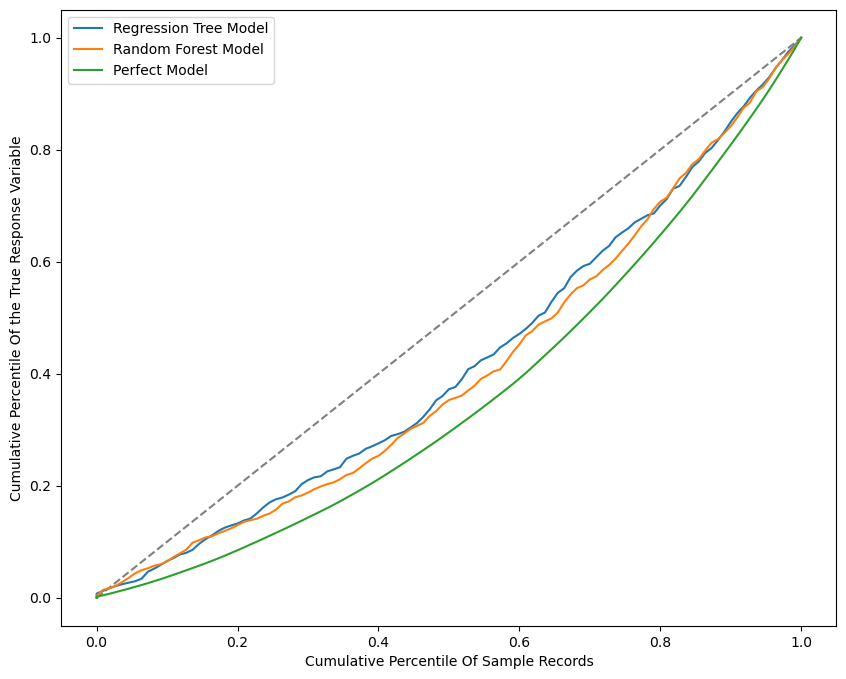

In [67]:
x_tree, y_tree = lorenz_courve(y_test,y_pred_tree)
x_forest, y_forest = lorenz_courve(y_test,y_pred_forest)
x_true,y_true = lorenz_courve(y_test,y_test)

plt.figure(figsize=(10,8))
plt.plot([0,1],[0,1], linestyle="--", color="grey")
plt.plot(x_tree, y_tree,label="Regression Tree Model")
plt.plot(x_forest, y_forest,label="Random Forest Model")
plt.plot(x_true,y_true,label="Perfect Model")
plt.legend()
plt.xlabel("Cumulative Percentile Of Sample Records")
plt.ylabel("Cumulative Percentile Of the True Response Variable")
plt.show()

## References
<a id="1">[1]</a> 
E. Furman, Y. Kye, and J. Su, “Computing the Gini index: A note,” <em>Economics Letters</em>, vol. 185, p. 108753, 2019.

<a id="2">[2]</a>
J. L. Gastwirth, “A General Definition of The Lorenz Curve,” <em>Econometrica</em>, vol. 39, no. 6, pp. 1037–1039, 1971.

<a id="3">[3]</a>
H. J. Greene and G. R. Milne, “Assessing Model Performance: The Gini Statistic and Its Standard Error,” <em>Journal of Database Marketing & Customer Strategy Management<\em>, vol. 17, pp. 36–48, 2010.